In [2]:
"""
@author: albertigno

"""

from MyDataset import *
import torch, time, os
import torch.nn as nn
import torch.nn.functional as F
#import networkx as nx
import matplotlib.pyplot as plt
#from matplotlib.gridspec import GridSpec

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ('Running on: {}'.format(device))

Running on: cuda:0


In [3]:
thresh = 0.3
batch_size = 256 # default 256
learning_rate = 1e-4 # default 1e-4
time_window = 50 # shd 50, nmnist 25-30
dataset_path = r'./../../datasets'

In [4]:
train_path = dataset_path+'/shd_digits/shd_train.h5'
test_path = dataset_path+'/shd_digits/shd_test.h5'
# load datasets
print("loading test set...")
test_dataset = MyDataset(test_path, 'hd_digits', time_window, device)
print("loading training set...")
train_dataset = MyDataset(train_path, 'hd_digits', time_window, device)
print("loading data with pytorch")
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)

loading test set...
num sample: 2264
torch.Size([2264, 50, 700]) torch.Size([2264, 20])
loading training set...
num sample: 8156
torch.Size([8156, 50, 700]) torch.Size([8156, 20])
loading data with pytorch


In [24]:
from snn_models import *
%load_ext autoreload
%autoreload 1
%aimport snn_models

num_hidden = 256
#tau_m = 'adp'
tau_m = 0.8305
#snn = RSNN_delay(d='shd', num_hidden=128, thresh=0.3, decay=0.3, batch_size=batch_size, win=50, device=device)
snn = RSNN('shd', num_hidden=num_hidden, thresh=0.3, tau_m=tau_m, vreset=0.0, batch_size=batch_size, win=time_window, device=device)
snn.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


RSNN(
  (fc_ih): Linear(in_features=700, out_features=256, bias=False)
  (fc_hh): Linear(in_features=256, out_features=256, bias=False)
  (fc_ho): Linear(in_features=256, out_features=20, bias=False)
)

In [25]:
# training configuration

num_epochs = 100
modelname = 'shd_rnn_{}_{}.t7'.format(snn.num_hidden, tau_m)
num_samples = train_dataset.images.size()[0]

# super pythonic way to extract the parameters that will have 'normal' learning rate
base_params = [getattr(snn,name.split('.')[0]).weight for name, _ in snn.state_dict().items() if name[0]=='f']

# setting different learning rate for tau_m, if neeeded
if tau_m=='adp':
    print('tau_m_h ')
    optimizer = torch.optim.Adam([
        {'params': base_params},
        {'params': snn.tau_m_h, 'lr': learning_rate * 10.0},
        {'params': snn.tau_m_o, 'lr': learning_rate * 10.0}],
        lr=learning_rate)
else:    
    optimizer = torch.optim.Adam([
        {'params': base_params}],
        lr=learning_rate)
    
act_fun = ActFun.apply
print(modelname)

shd_rnn_256_0.8305.t7


In [60]:
zero_mask = torch.zeros((num_hidden,num_hidden), device=snn.device)
inh_strength = 1e-3
wta_mask = -inh_strength*torch.ones((num_hidden,num_hidden), device=snn.device) + inh_strength*torch.eye(num_hidden, device=snn.device)

snn.mask_weights(snn.fc_hh, wta_mask, override = True, trainable=False )


In [61]:
wta_mask

tensor([[ 0.0000, -0.0010, -0.0010,  ..., -0.0010, -0.0010, -0.0010],
        [-0.0010,  0.0000, -0.0010,  ..., -0.0010, -0.0010, -0.0010],
        [-0.0010, -0.0010,  0.0000,  ..., -0.0010, -0.0010, -0.0010],
        ...,
        [-0.0010, -0.0010, -0.0010,  ...,  0.0000, -0.0010, -0.0010],
        [-0.0010, -0.0010, -0.0010,  ..., -0.0010,  0.0000, -0.0010],
        [-0.0010, -0.0010, -0.0010,  ..., -0.0010, -0.0010,  0.0000]],
       device='cuda:0')

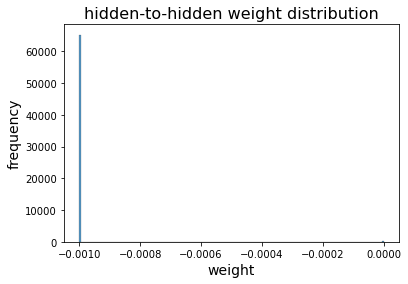

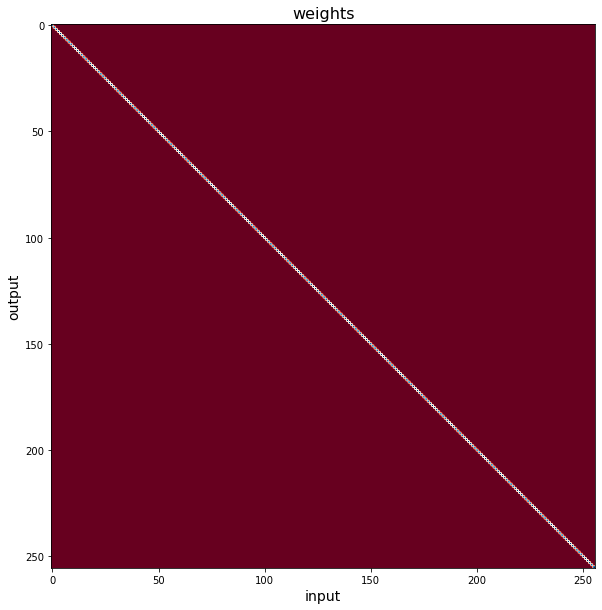

In [62]:
w = snn.plot_weights('hh', 'histogram')
w = snn.plot_weights('hh', 'matrix')

In [26]:
# training loop
taus_m = []
for epoch in range(num_epochs):
    print('Epoch [%d/%d]'  % (epoch + 1, num_epochs))
    start_time = time.time()
    snn.train_step(train_loader, optimizer=optimizer, criterion=nn.MSELoss(), num_samples = num_samples)
    t = time.time() - start_time
    print('Time elasped:', time.time() - start_time)
    
    # update learning rate
    optimizer = snn.lr_scheduler(optimizer, lr_decay_epoch=1)
    
    # weight and decay recording
    # taus_m.append((snn.tau_m_h.data.detach().clone(), snn.tau_m_o.data.detach().clone()))
    
    if (epoch+1) % 5 ==0:
        snn.test(test_loader, criterion=nn.MSELoss())
        snn.save_model(modelname)   
                
with open('training_log', 'a') as logs:
    logs.write("\nFinished training {} epochs for {}, batch_size {}, time_per_epoch {} s".format(num_epochs, modelname, batch_size, t))       

Epoch [1/100]
Step [10/31], Loss: 0.49989
Step [20/31], Loss: 0.47972
Step [30/31], Loss: 0.47193
Time elasped: 2.220447063446045
Epoch [2/100]
Step [10/31], Loss: 0.46320
Step [20/31], Loss: 0.45443
Step [30/31], Loss: 0.44902
Time elasped: 2.2244317531585693
Epoch [3/100]
Step [10/31], Loss: 0.44179
Step [20/31], Loss: 0.43603
Step [30/31], Loss: 0.43208
Time elasped: 2.206871509552002
Epoch [4/100]
Step [10/31], Loss: 0.42686
Step [20/31], Loss: 0.42297
Step [30/31], Loss: 0.41558
Time elasped: 2.19411301612854
Epoch [5/100]
Step [10/31], Loss: 0.41137
Step [20/31], Loss: 0.40813
Step [30/31], Loss: 0.39924
Time elasped: 2.221869707107544
Test Accuracy of the model on the test samples: 36.914
Epoch [6/100]
Step [10/31], Loss: 0.38900
Step [20/31], Loss: 0.38241
Step [30/31], Loss: 0.37305
Time elasped: 2.242300510406494
Epoch [7/100]
Step [10/31], Loss: 0.36763
Step [20/31], Loss: 0.36902
Step [30/31], Loss: 0.35938
Time elasped: 2.2088708877563477
Epoch [8/100]
Step [10/31], Loss: 

Step [10/31], Loss: 0.18416
Step [20/31], Loss: 0.18324
Step [30/31], Loss: 0.18890
Time elasped: 2.480451822280884
Epoch [60/100]
Step [10/31], Loss: 0.18564
Step [20/31], Loss: 0.19129
Step [30/31], Loss: 0.19420
Time elasped: 2.3024346828460693
Test Accuracy of the model on the test samples: 66.797
Epoch [61/100]
Step [10/31], Loss: 0.18603
Step [20/31], Loss: 0.18178
Step [30/31], Loss: 0.17934
Time elasped: 2.3024260997772217
Epoch [62/100]
Step [10/31], Loss: 0.17462
Step [20/31], Loss: 0.18397
Step [30/31], Loss: 0.17941
Time elasped: 2.315246105194092
Epoch [63/100]
Step [10/31], Loss: 0.17703
Step [20/31], Loss: 0.17332
Step [30/31], Loss: 0.18081
Time elasped: 2.2181599140167236
Epoch [64/100]
Step [10/31], Loss: 0.17911
Step [20/31], Loss: 0.17462
Step [30/31], Loss: 0.17750
Time elasped: 2.2583534717559814
Epoch [65/100]
Step [10/31], Loss: 0.18097
Step [20/31], Loss: 0.17856
Step [30/31], Loss: 0.17806
Time elasped: 2.2937679290771484
Test Accuracy of the model on the test

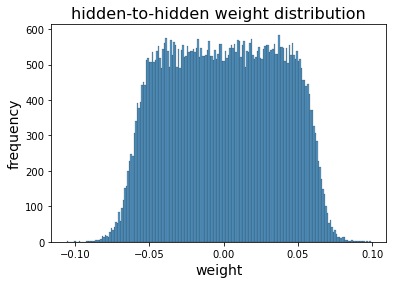

In [19]:
w = snn.plot_weights('hh', 'histogram')

In [20]:
snn.save_to_numpy(modelname.split('.')[0])

In [ ]:
snn.load()

<AxesSubplot:ylabel='Count'>

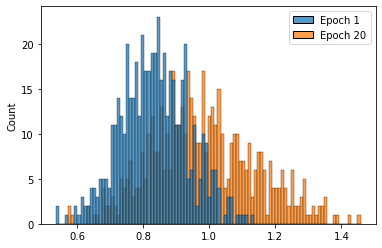

In [8]:
import seaborn as sns
import pandas as pd

initial_taus = taus_m[0][0].cpu().numpy()
final_taus = taus_m[-1][0].cpu().numpy()

df = pd.DataFrame(initial_taus, columns=['Epoch 1'])
df['Epoch {}'.format(len(taus_m))] = final_taus

sns.histplot(data=df, bins=100)

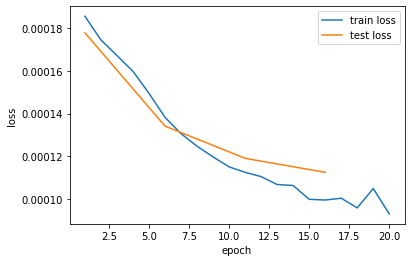

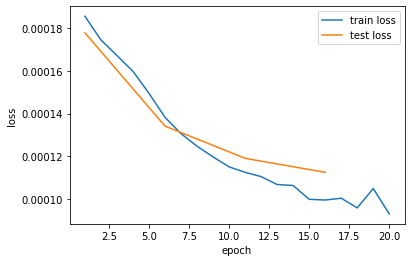

In [9]:
snn.plot_loss()

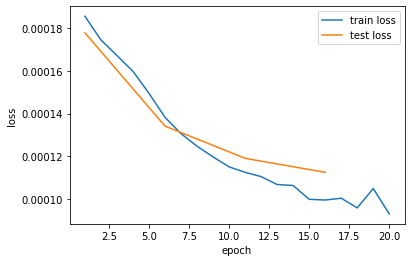

In [10]:
loss_fig = snn.plot_loss()

In [21]:
m = RSNN()

In [22]:
m.load_model(modelname, 256, device)

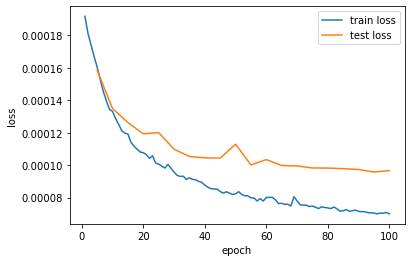

In [23]:
loss_fig = m.plot_loss()